Based on [qiskit lab](https://qiskit.org/textbook/ch-algorithms/teleportation.html) and [qbronze lab](https://gitlab.com/qworld/bronze-qiskit/-/blob/master/quantum-with-qiskit/Q76_Quantum_Teleportation.ipynb).

## How it works?

### What do we want

$|\psi\rangle\otimes|00\rangle \rightarrow |00\psi\rangle$

### Idea of teleportation

Having an entagled pair of qubits, shared between to participants, transer a state on arbitrary qubit to the state of reciever.

$|\psi\rangle\otimes|00\rangle \rightarrow |\psi\rangle\otimes\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right) \rightarrow |00\psi\rangle$

### Idea of implementation

$(\alpha|0\rangle+\beta|1\rangle)\otimes\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right)$

$\frac{1}{\sqrt{2}}(\alpha|000\rangle+\beta|100\rangle+\alpha|011\rangle+\beta|111\rangle)$

$\frac{1}{\sqrt{2}}(\alpha|00\rangle\otimes|0\rangle+\beta|10\rangle\otimes|0\rangle+\alpha|01\rangle\otimes|1\rangle+\beta|11\rangle\otimes|1\rangle)$


Measure teleported qubit and one on entangled in Bell's basis. If the state we observe is $|\Phi^+\rangle$:

$\frac{1}{\sqrt{2}}(\alpha\langle\Phi^+|00\rangle\otimes|0\rangle+\beta\langle\Phi^+|10\rangle\otimes|0\rangle+\alpha\langle\Phi^+|01\rangle\otimes|1\rangle+\beta\langle\Phi^+|11\rangle\otimes|1\rangle)$

Middle terms are impossible to observe (there is no $|00\rangle$ component in $|\Phi^+\rangle$ state). Both other have equal probability and $\langle\Phi^+|00\rangle=\frac{1}{\sqrt{2}}$

$\frac{1}{\sqrt{2}} \left(\alpha\frac{1}{\sqrt{2}}|0\rangle + \beta\frac{1}{\sqrt{2}}|1\rangle\right)$

But what is oberved state is $|\Psi^-\rangle$? We need to fix the phase with $Z$ (to fix minus to plus) and negate a qubit with $X$!

### Implementation time!

Learn what is [`c_if(classic, value)`](https://quantumcomputing.stackexchange.com/questions/9372/how-to-implement-if-statement-based-on-measurement-results-in-qiskit) condition and how to apply it.

Entangle


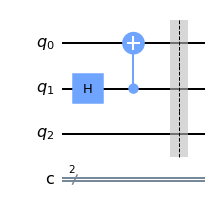

Send one to reciever


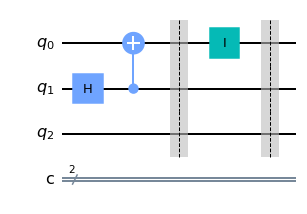

What will we teleport? Prepare SOME state


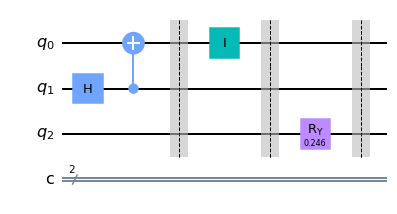

Measure on sender's side in Bell's basis


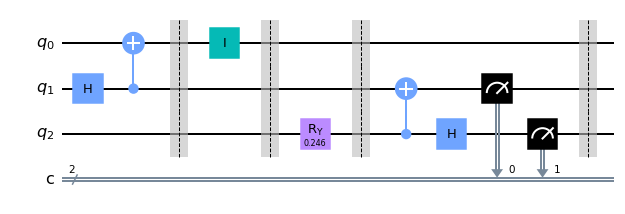

Post-processing: if state is different from Ф+
the state vector is
[0.       0.       0.992445 0.12269  0.       0.       0.       0.      ]
Look here >>>>>>>>>>>>>>>: 0.1230002619213948


In [23]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
import matplotlib.pyplot as plt
import qiskit
sv = qiskit.quantum_info.random_statevector(2)

# quantum circuit with three qubits and two bits
qr =  QuantumRegister(3, "q") 
cr = ClassicalRegister(2, "c") 
qc = QuantumCircuit(qr, cr)

# creating an entanglement between q[1] and q[0]
print("Entangle")
qc.h(qr[1])
qc.cx(qr[1], qr[0])
qc.barrier()

qc.draw(output='mpl')
plt.show()

# transfer one of qubits to recieving party
print("Send one to reciever")
qc.i(qr[0])
qc.barrier()
qc.draw(output='mpl')
plt.show()


# prepare a qubit on sender's side
print("What will we teleport? Prepare SOME state")
qc.ry(0.123 * 2, qr[2])
qc.barrier()
qc.draw(output='mpl')
plt.show()


# measure the qubit in Bell state
print("Measure on sender's side in Bell's basis")
qc.cx(qr[2], qr[1])
qc.h(qr[2])
qc.measure(qr[1:], cr)  # 2 last qubits
qc.barrier()

qc.draw(output='mpl')
plt.show()

print("Post-processing: if state is different from Ф+")
qc.x(qr[0]).c_if(cr[0], 1)
qc.z(qr[0]).c_if(cr[1], 1)


# read the state vector
job = execute(qc, Aer.get_backend('statevector_simulator'), optimization_level=0, shots=1)
current_quantum_state = abs(job.result().get_statevector(qc, decimals=6))
print("the state vector is")
print(current_quantum_state)

i = 0
while current_quantum_state[i] == 0.0:
    i += 1

cos = current_quantum_state[i]
from math import acos
print("Look here >>>>>>>>>>>>>>>:", acos(cos))

[IBM](https://qiskit.org/textbook/ch-algorithms/teleportation.html): The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the deferred measurement principle discussed in chapter 4.4 of [this book](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf). The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

